# Attention intuition

The lecture notes on Deep Learning from [Francois Fleuret](https://fleuret.org/dlc/materials/dlc-handout-13-2-attention-mechanisms.pdf) contain a very nice intuition on why and where the attention mechanism works better than conv nets.

In the example, he considers a toy sequence-to-sequence problem with triangular and rectangular shapes with random heights as input.
The expected target contains the same shapes but with their heights averaged, as in the figure below.


![](images/data_example.png)

Since there was no source code available in his lecture (as far as I know), I have tried to reproduce the same intuition in this notebook.
As we can see, with the exact training procedure, the attention mechanism is able to learn the task much faster than the conv net.
The conv net model's poor performance is expected due to its inability to look far away the input signal to learn the task.
There are plenty of mechanisms we can equip the conv net with to make it work better (more layers, fully connected layers, ...), but the attention mechanism is a very simple and elegant solution to this problem.



## Dataset

Follow below one example of the dataset with the input and its corresponding target

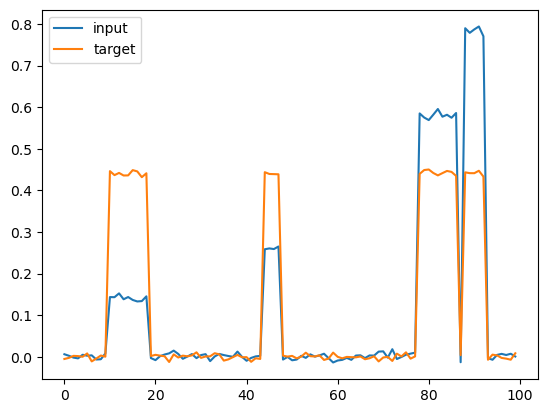

In [6]:
import numpy as np
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Please, set the device according to your setup
DEVICE = "cuda"
SIZE = 100

np.random.seed(18)


def norm_0_1(X):
    return (X - X.min()) / (X.max() - X.min())

def norm_height(X, max_height):
    #return (X - X.min()) / (X.max() - X.min())
    return X / max_height


@dataclass
class ShapeLog:
    """
    A class to store the information about the shapes in the image
    """

    shape_type: str
    base_point: int
    width: int
    height: int


def generate_pair(size: int = 100, max_height: int = 50, noise_std: float = 0.3, num_shapes:int = 4):
    """
    Generate a pair of images. One with the randomly generated sequence of triangles and/or rectangles
    and the other one with the average hights of the shapes in the first image.

    Args:
        size: The size of the image on the x axis
        max_hight: The maximum hight of the shapes

    Returns:
        A tuple of two images. The first one is the image with the shapes and the second one is the image with the average hight of the shapes
    """

    min_height = 5
    base_size_range = [3, 10]

    shape_choices = ["triangle", "rectangle"]
    # shape_choices = ["triangle"]    
    shape_logs = []

    input = np.zeros(size)

    def draw(input, shape_log):
        if shape_log.shape_type == "triangle":
            pick_point = (shape_log.base_point + (shape_log.base_point + shape_log.width)) // 2
            input[pick_point] = shape_log.height

            # Computing the triangle's first ramp
            num_points = pick_point - shape_log.base_point
            values = np.linspace(0, shape_log.height, num=num_points, endpoint=False, dtype=int)
            input[shape_log.base_point : (shape_log.base_point + shape_log.width // 2)] = values

            # Computing the triangle's second ramp
            num_points = (shape_log.base_point + shape_log.width) - pick_point
            values = np.linspace(shape_log.height, 0, num=num_points, endpoint=False, dtype=int)

            word_size = min(size, shape_log.base_point + shape_log.width) - (
                shape_log.base_point + shape_log.width // 2
            )
            input[
                (shape_log.base_point + shape_log.width // 2) : min(size, shape_log.base_point + shape_log.width)
            ] = values[0:word_size]


        else:
            # Rectangle
            input[shape_log.base_point : (shape_log.base_point + shape_log.width)] = shape_log.height

        return input
        

    def average_shapelogs_per_type(shape_logs):
        averages = {}
        for shape in shape_choices:
            averages[shape] = np.mean([s.height for s in shape_logs if s.shape_type == shape])

        input_averages = np.zeros(size)
        for shape in shape_logs:
            shape.height = averages[shape.shape_type]
            input_averages = draw(input_averages, shape)

        return input_averages

    def remove_overlaps(shape_logs):
        # Removing basic overlaps (it has some flaws, but f*** *t)
        
        for i in range(len(shape_logs)-1):            
            
            # Check overlap
            if shape_logs[i].base_point+shape_logs[i].width > shape_logs[i+1].base_point:
                if i<num_shapes//2:
                    shape_logs[i].base_point -= max(0,shape_logs[i].base_point+shape_logs[i].width)-shape_logs[i+1].base_point-1
                else:
                    shape_logs[i].base_point += min(size,shape_logs[i].base_point+shape_logs[i].width)-shape_logs[i+1].base_point+1
        
        # Treating the last one
        if shape_logs[-1].base_point+shape_logs[-1].width > shape_logs[-2].base_point:
            shape_logs[-1].base_point = min(size,shape_logs[-2].base_point+shape_logs[-2].width)+1

        return shape_logs


    # Picking the middle points
    #base_points = sorted(np.random.uniform(0,100, size=num_shapes).astype("uint"))                
    seeds = [(i*(size//num_shapes), i*(size//num_shapes) + size//num_shapes) for i in range(num_shapes)]    
    base_points = [np.random.randint(mi, ma) for mi,ma in seeds]        
    widths = np.random.randint(base_size_range[0], base_size_range[1], size=num_shapes)
    heights = np.random.randint(min_height, max_height, size=num_shapes)                       
    shapes = np.random.choice(shape_choices, num_shapes)
    
    shape_logs = [
        ShapeLog(shape_type, base_point, width, height)
        for shape_type, base_point, width, height in zip(shapes, base_points, widths, heights)
    ]
    
    shape_logs = remove_overlaps(shape_logs)

    for shape in shape_logs:
        input = draw(input, shape)
                         
    input += np.random.normal(0, noise_std, size)

    target = average_shapelogs_per_type(shape_logs) + np.random.normal(0, noise_std, size)

    #return np.expand_dims(input, axis=0).astype(np.float32), np.expand_dims(target, axis=0).astype(np.float32)    

    input = norm_height(input, max_height) 
    target = norm_height(target, max_height)

    input = np.expand_dims(input, axis=0).astype(np.float32)
    target = np.expand_dims(target, axis=0).astype(np.float32)

    return input, target


class ShapeDataset(Dataset):
    def __init__(self, max_samples=1000, size=100, max_height=50, noise_std=0.3):
        """
        Shape dataset.
        It generates a pair of images. One with the randomly generated sequence of triangles and/or rectangles
        and the other one with the average hights of the shapes in the first image.

        Args:
            max_samples: The number of samples to generate
            size: The size of the image on the x axis
            max_hight: The maximum hight of the shapes
            noise_std: The standard deviation of the noise to add to the images

        """
        self.images = [generate_pair(size=size, max_height=max_height, noise_std=noise_std) for _ in range(max_samples)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx][0], self.images[idx][1]


original, target = generate_pair()
# Plotting the dataset
fig = plt.figure()

plt.plot(range(len(original[0][0:SIZE])), original[0][0:SIZE], label="input")
plt.plot(range(len(target[0][0:SIZE])), target[0][0:SIZE], label="target")
plt.legend()


## Training the models

Training with conv model
Epoch: 0, Loss: 0.0032252289820462465
Epoch: 10, Loss: 0.002629475435242057
Epoch: 20, Loss: 0.002717725932598114
Epoch: 30, Loss: 0.002241553505882621
Epoch: 40, Loss: 0.0026632880326360464
Training with attention model
Epoch: 0, Loss: 0.0019773642998188734
Epoch: 10, Loss: 0.0008047588053159416
Epoch: 20, Loss: 0.0001325677294516936
Epoch: 30, Loss: 6.389737245626748e-05
Epoch: 40, Loss: 9.38402590691112e-05


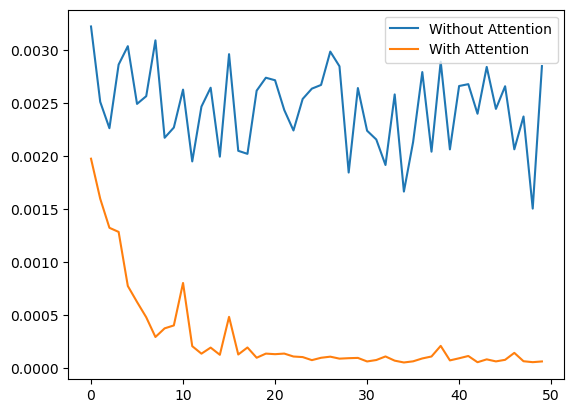

In [7]:
# Implementation of the self attention layer
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, key_dim):
        super().__init__()
        self.conv_Q = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        self.conv_K = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        self.conv_V = nn.Conv1d(in_dim, out_dim, kernel_size=1, bias=False)

    def forward(self, x):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        A = Q.transpose(1, 2).matmul(K).softmax(2)
        y = A.matmul(V.transpose(1, 2)).transpose(1, 2)
        return y
    
    def forward_attention(self, x):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        A = Q.transpose(1, 2).matmul(K).softmax(2)
        return A
    
def train_model(model, epochs=20, device="cuda"):
    train_loader = torch.utils.data.DataLoader(
        dataset=ShapeDataset(size=100, max_height=50, noise_std=0.3, max_samples=10000),
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

    model.train()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    loss_per_epoch = []    
    for epoch in range(epochs):
        for i, (input, target) in enumerate(train_loader):
            input = input.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        if epoch%10==0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")
        loss_per_epoch.append(loss.item())

    return loss_per_epoch


# Training the regular model with no self attention

print("Training with conv model")
conv_model = nn.Sequential(
    nn.Conv1d(1, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 1, kernel_size=(5,), padding="same"),
)
loss_per_epoch_conv = train_model(conv_model, epochs=50, device=DEVICE)


# Training with self attention
print("Training with attention model")
attention_model = nn.Sequential(
    nn.Conv1d(1, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    SelfAttentionLayer(in_dim=64, out_dim=64, key_dim=64),
    nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
    nn.ReLU(),
    nn.Conv1d(64, 1, kernel_size=(5,), padding="same"),
)
loss_per_epoch_attention = train_model(attention_model, epochs=50, device=DEVICE)

plt.figure()
plt.plot(loss_per_epoch_conv, label="Without Attention")
plt.plot(loss_per_epoch_attention, label="With Attention")
plt.legend()

## Visualizations

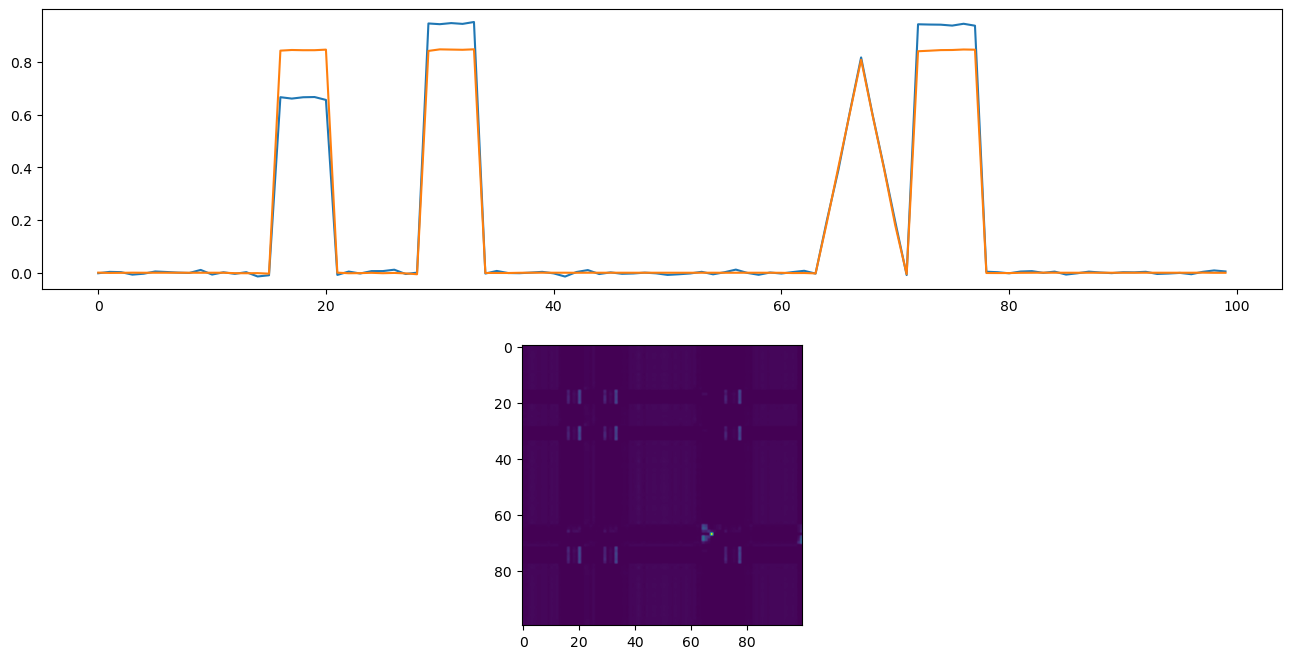

In [9]:
original, target = generate_pair()
attention_model.eval()

input_tensor = torch.Tensor(np.expand_dims(original,axis=0))
input_tensor = input_tensor.to(DEVICE)

attention = None
x = input_tensor
for layer in attention_model:    
    if isinstance(layer, SelfAttentionLayer):
        attention = layer.forward_attention(x)
    x = layer(x)

attention = attention[0].detach().to("cpu").numpy()
predicted = x[0][0].detach().to("cpu").numpy()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
plt.imshow(attention)
ax1.plot(range(len(original[0])), original[0], label="input")
ax1.plot(range(len(original[0])), predicted, label="predicted target")
#plt.legend()
